In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sn
import os
from wordcloud import STOPWORDS
import fasttext
import fasttext.util


2025-04-13 11:01:35.294846: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 11:01:35.313069: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 11:01:35.450600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 11:01:35.551514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744520495.641456   12175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744520495.66

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
# Load dataset
print("Loading datasets...")
train_data = pd.read_csv('../Dataset/train.csv')
validation_data = pd.read_csv('../Dataset/validation.csv')
df_content_language = pd.read_csv('../Dataset/test.csv')
df_toxicity = pd.read_csv('../Dataset/test_labels.csv')

# Merge test datasets on the 'id' column
test_data = pd.merge(df_content_language, df_toxicity, on='id')
print("Test data shape:", test_data.shape)
print("Validation data shape:", validation_data.shape)

# Check language distribution in test data
if 'lang' in test_data.columns:
    print("Languages in test data:")
    print(test_data['lang'].value_counts())

    # Get list of languages in our dataset
    languages = test_data['lang'].unique().tolist()
    print(f"Unique languages: {languages}")
else:
    print("No language column found in test data")
    languages = ['en']  # Default to English if no language info

Loading datasets...
Test data shape: (6000, 4)
Validation data shape: (840, 4)
Languages in test data:
lang
tr    1341
pt    1059
fr    1026
ru    1018
it     799
es     757
Name: count, dtype: int64
Unique languages: ['tr', 'ru', 'it', 'fr', 'pt', 'es']


In [6]:
# Remove stopwords & convert to lower case
train_data['feedback_text'] = train_data['feedback_text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

# Remove Punctuations
train_data["feedback_text"] = train_data['feedback_text'].str.replace(r'[^\w\s]', '', regex=True)

In [8]:
#Feature Engineering
# word_count
train_data['word_count'] = train_data['feedback_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['feedback_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['feedback_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
train_data['mean_word_length'] = train_data['feedback_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['feedback_text'].apply(lambda x: len(str(x)))


In [11]:
# Prepare training labels
train_data['toxics'] = train_data[['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']].sum(axis=1) > 0
train_data['toxics'] = train_data['toxics'].astype(int)
train_data.drop(['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry'], inplace=True, axis=1)

# Limit training data for faster processing (if needed)
train_data = train_data.loc[:15000, :]
print("Training data shape after limiting:", train_data.shape)

# Display label distribution
print("Toxicity label distribution:")
print(train_data["toxics"].value_counts())

Training data shape after limiting: (15001, 8)
Toxicity label distribution:
toxics
0    13525
1     1476
Name: count, dtype: int64


/tmp/ipykernel_12175/1194427503.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.loc[~TOXIC_COMMENTS][feature], label='Non Toxic', ax=axes[i][0], color='green')
/tmp/ipykernel_12175/1194427503.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.loc[TOXIC_COMMENTS][featur

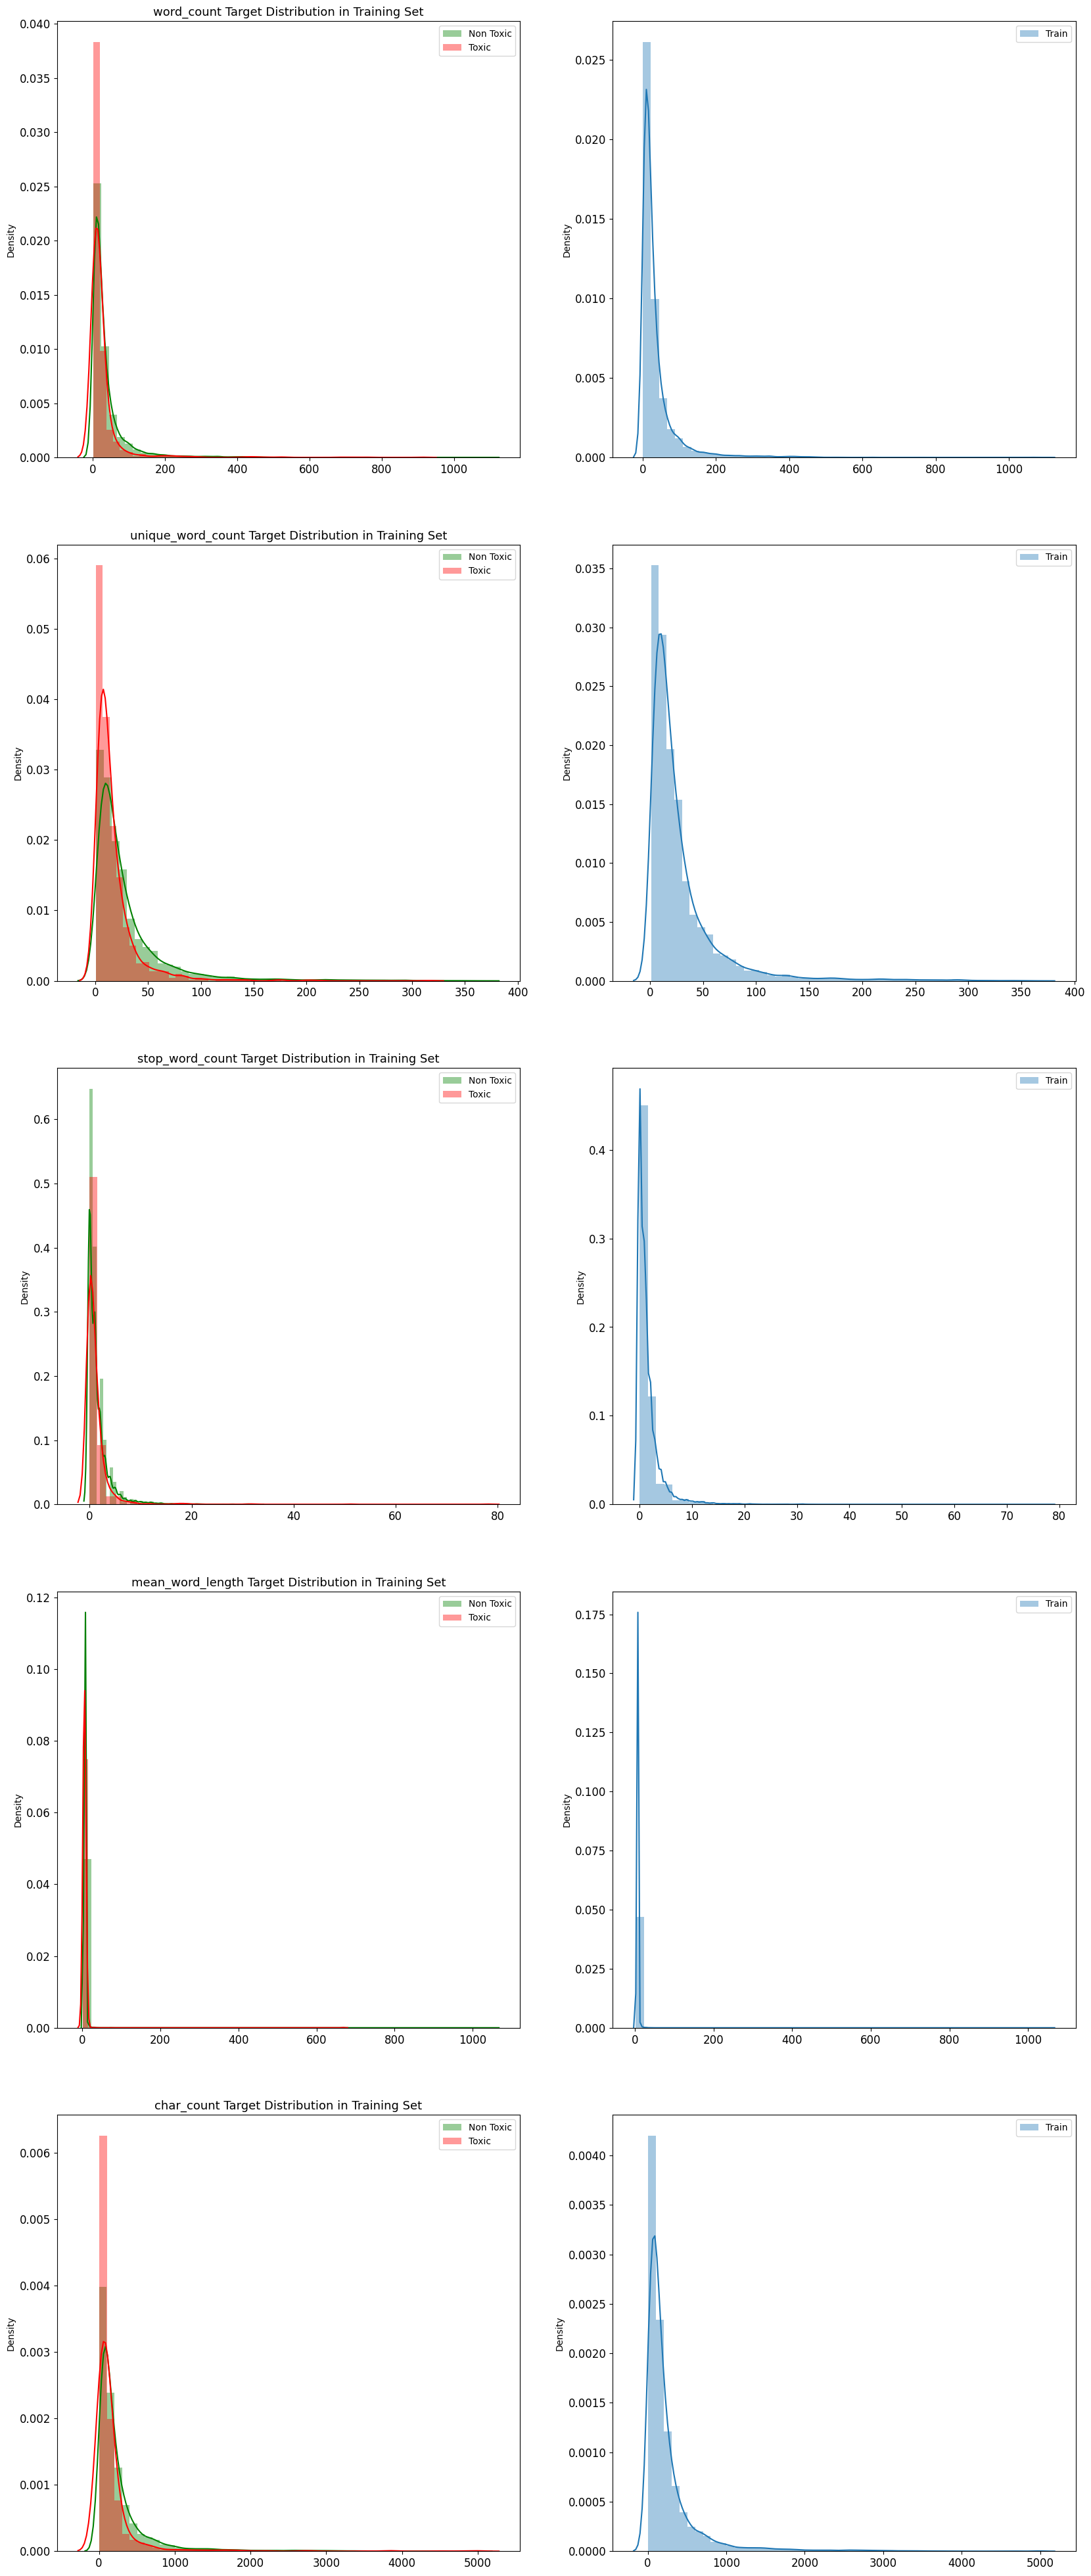

In [12]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length','char_count']
TOXIC_COMMENTS = train_data['toxics'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~TOXIC_COMMENTS][feature], label='Non Toxic', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[TOXIC_COMMENTS][feature], label='Toxic', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Train', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)

plt.show()

In [8]:
# Prepare validation and test data labels
for dataset, name in [(validation_data, 'validation'), (test_data, 'test')]:
    if all(col in dataset.columns for col in ['toxic']):
        dataset['toxics'] = dataset[['toxic']].sum(axis=1) > 0
        dataset['toxics'] = dataset['toxics'].astype(int)
        dataset.drop(['toxic'], inplace=True, axis=1)
        print(f"{name.capitalize()} toxicity distribution:")
        print(dataset['toxics'].value_counts())

# Load FastText models for the languages in our dataset
# We'll map ISO language codes to FastText language codes
lang_mapping = {
    'en': 'en',  # English
    'fr': 'fr',  # French
    'es': 'es',  # Spanish
    'de': 'de',  # German
    'it': 'it',  # Italian
    'pt': 'pt',  # Portuguese
    'nl': 'nl',  # Dutch
    'ru': 'ru',  # Russian
    'zh': 'zh',  # Chinese
    'ar': 'ar',  # Arabic
    'ja': 'ja',  # Japanese
    'ko': 'ko',  # Korean
    'hi': 'hi',  # Hindi
    # Add more mappings as needed
}

Validation toxicity distribution:
toxics
0    706
1    134
Name: count, dtype: int64
Test toxicity distribution:
toxics
0    4637
1    1363
Name: count, dtype: int64


In [9]:
# Default to English for languages not in our mapping
default_lang = 'en'

# Function to download FastText models for languages in our dataset
def download_fasttext_models(languages):
    fasttext_models = {}

    for lang in languages:
        # Map the dataset language code to FastText language code
        ft_lang = lang_mapping.get(lang, default_lang)

        # Skip if we already downloaded this language model
        if ft_lang in fasttext_models:
            continue

        model_path = f'cc.{ft_lang}.300.bin'

        # Check if model already exists
        if os.path.exists(model_path):
            print(f"Loading existing FastText model for {ft_lang}...")
            try:
                fasttext_models[ft_lang] = fasttext.load_model(model_path)
                print(f"Loaded model for {ft_lang}")
            except Exception as e:
                print(f"Error loading model for {ft_lang}: {e}")
        else:
            # Try to download the model
            print(f"Downloading FastText model for {ft_lang}...")
            try:
                fasttext.util.download_model(ft_lang, if_exists='ignore')
                fasttext_models[ft_lang] = fasttext.load_model(model_path)
                print(f"Downloaded and loaded model for {ft_lang}")
            except Exception as e:
                print(f"Error downloading model for {ft_lang}: {e}")

    # Make sure we have at least the default language model
    if default_lang not in fasttext_models:
        model_path = f'cc.{default_lang}.300.bin'
        print(f"Downloading default FastText model ({default_lang})...")
        try:
            fasttext.util.download_model(default_lang, if_exists='ignore')
            fasttext_models[default_lang] = fasttext.load_model(model_path)
            print(f"Downloaded and loaded default model for {default_lang}")
        except Exception as e:
            print(f"Error downloading default model: {e}")
            print("Will use random embeddings instead")

    return fasttext_models

In [10]:
# Text preprocessing
def preprocess_text(texts):
    # Simple preprocessing - convert to lowercase and handle NaN values
    return [str(text).lower() for text in texts]

# Preprocess all datasets
train_texts = preprocess_text(train_data["feedback_text"].fillna("").tolist())
validation_texts = preprocess_text(validation_data["feedback_text"].fillna("").tolist())
test_texts = preprocess_text(test_data["content"].fillna("").tolist())

In [11]:
# Tokenize texts
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts + validation_texts + test_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Determine the maximum sequence length
maxlen = 1000  # Adjust based on your needs and computational resources

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_validation = pad_sequences(validation_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)

Vocabulary size: 121838


In [12]:
# Prepare labels
y_train = train_data["toxics"].values
if 'toxics' in validation_data.columns:
    y_validation = validation_data["toxics"].values
else:
    y_validation = np.zeros(len(validation_data))

if 'toxics' in test_data.columns:
    y_test = test_data["toxics"].values
else:
    y_test = np.zeros(len(test_data))

# Get language models for all languages in our dataset
if 'lang' in test_data.columns:
    dataset_languages = test_data['lang'].unique().tolist()
else:
    dataset_languages = [default_lang]  # Default to English if no language info

In [13]:
# For simplicity in this example, let's use just one model (English)
# In a production system, you might want to download models for all languages
print("Using English FastText model for all languages in this example")
dataset_languages = [default_lang]

# Download FastText models
fasttext_models = download_fasttext_models(dataset_languages)
embedding_dim = 300  # FastText models use 300 dimensions

# Create embedding matrix using FastText
print("Creating embedding matrix using FastText...")
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Use the default language model for all words
default_model = fasttext_models.get(default_lang)

if default_model:
    for word, i in tqdm(word_index.items()):
        try:
            embedding_vector = default_model.get_word_vector(word)
            embedding_matrix[i] = embedding_vector
        except:
            # Keep zeros for words not in the model
            continue
else:
    # Fallback to random embeddings if no model is available
    print("No FastText models available, using random embeddings")
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size, embedding_dim))

print("Embedding matrix created")

Using English FastText model for all languages in this example

Downloaded and loaded model for en
Creating embedding matrix using FastText...


100%|██████████| 121837/121837 [00:03<00:00, 38583.95it/s]

Embedding matrix created


In [14]:
# Build the model with FastText embeddings
with strategy.scope():
    model = Sequential()
    model.add(Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False  # Keep FastText embeddings fixed
    ))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    36,551,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,551,400 (139.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 36,551,400 (139.43 MB)

In [16]:
# Train the model
batch_size = 32
epochs = 4

history = model.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 3148s 7s/step - accuracy: 0.9074 - loss: 0.2909 - val_accuracy: 0.8452 - val_loss: 0.5526
Epoch 2/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2913s 6s/step - accuracy: 0.9311 - loss: 0.1915 - val_accuracy: 0.8429 - val_loss: 0.6034
Epoch 3/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2968s 6s/step - accuracy: 0.9359 - loss: 0.1739 - val_accuracy: 0.8440 - val_loss: 0.6872
Epoch 4/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2976s 6s/step - accuracy: 0.9389 - loss: 0.1740 - val_accuracy: 0.8440 - val_loss: 0.6954


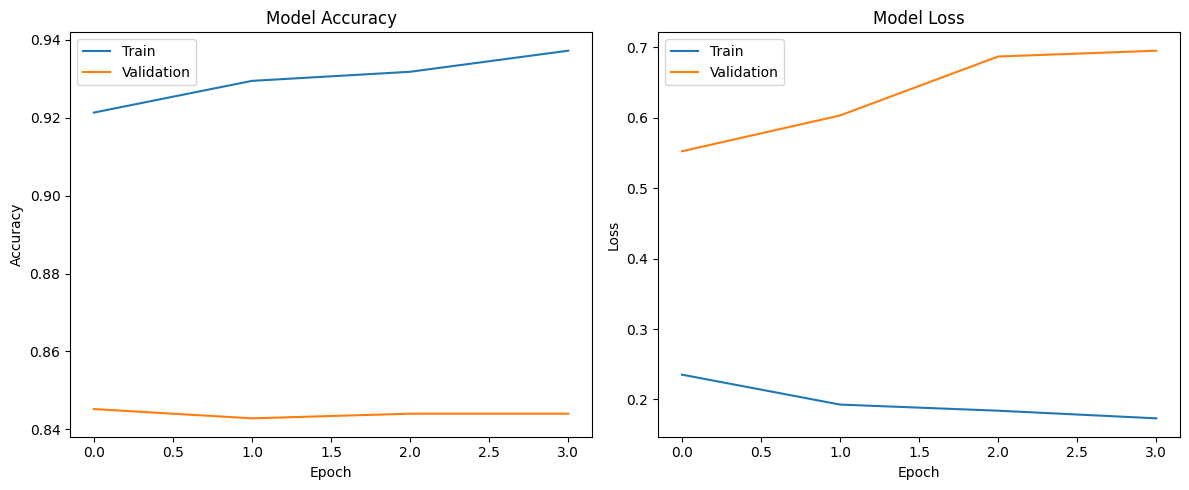

In [17]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model on test data
print("Evaluating model on test data...")
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

Evaluating model on test data...
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step


Test Accuracy: 0.7738333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4637
           1       0.64      0.01      0.02      1363

    accuracy                           0.77      6000
   macro avg       0.71      0.50      0.45      6000
weighted avg       0.74      0.77      0.68      6000



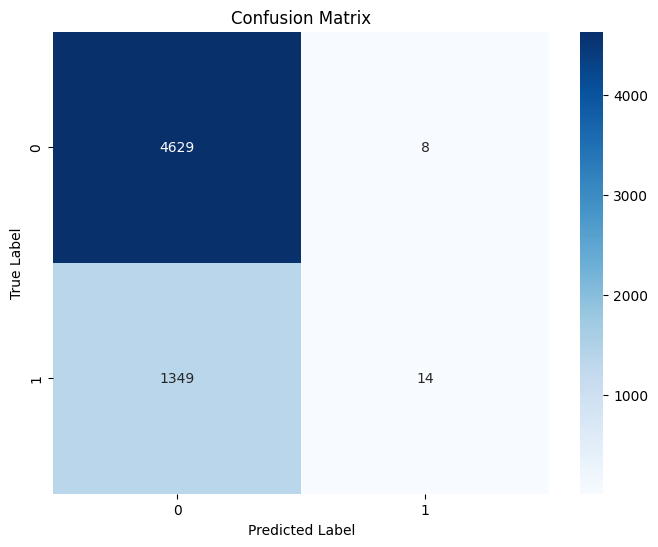


Performance by language:
Language: tr, Samples: 1341, Accuracy: 0.8904
Language: ru, Samples: 1018, Accuracy: 0.7633
Language: it, Samples: 799, Accuracy: 0.8048
Language: fr, Samples: 1026, Accuracy: 0.6988
Language: pt, Samples: 1059, Accuracy: 0.8253
Language: es, Samples: 757, Accuracy: 0.5786


In [19]:
# If test data has labels, evaluate the performance
if 'toxics' in test_data.columns:
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Analyze performance by language
    if 'lang' in test_data.columns:
        test_data['predicted'] = y_pred
        print("\nPerformance by language:")
        for lang in test_data['lang'].unique():
            lang_subset = test_data[test_data['lang'] == lang]
            if len(lang_subset) > 0 and 'toxics' in lang_subset.columns:
                acc = accuracy_score(lang_subset['toxics'], lang_subset['predicted'])
                print(f"Language: {lang}, Samples: {len(lang_subset)}, Accuracy: {acc:.4f}")
else:
    # If no labels, just save predictions
    print("No labels in test data. Saving predictions...")
    test_data['predicted_toxic'] = y_pred
    test_data.to_csv('test_predictions.csv', index=False)